In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('ggplot')

In [2]:
control = pd.read_csv('control_data.csv')
exper = pd.read_csv('experiment_data.csv')

In [3]:
control_ep = control.dropna()
exper_ep = exper.dropna()

In [4]:
control_ep['click_through'] = control_ep['Clicks'] / control_ep['Pageviews']
exper_ep['click_through'] = exper_ep['Clicks'] / exper_ep['Pageviews']

<ipython-input-4-bf9a39e53d92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_ep['click_through'] = control_ep['Clicks'] / control_ep['Pageviews']
<ipython-input-4-bf9a39e53d92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exper_ep['click_through'] = exper_ep['Clicks'] / exper_ep['Pageviews']


In [5]:
control_ep['Enrollment_rate'] = control_ep['Enrollments'] / control_ep['Clicks']
control_ep['payment_rate'] = control_ep['Payments'] / control_ep['Clicks']
exper_ep['Enrollment_rate'] = exper_ep['Enrollments'] / exper_ep['Clicks']
exper_ep['payment_rate'] = exper_ep['Payments'] / exper_ep['Clicks']

<ipython-input-5-dc27e09d9d92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_ep['Enrollment_rate'] = control_ep['Enrollments'] / control_ep['Clicks']
<ipython-input-5-dc27e09d9d92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_ep['payment_rate'] = control_ep['Payments'] / control_ep['Clicks']
<ipython-input-5-dc27e09d9d92>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

First Step:

Plot the Binomial Distribution for each control and experiment and compare the overlap between the two peaks visually.  Trying to find "true conversion rate"

Number of trials= "Clicks"
Number of successes= "Enrollments"

We'll find conversion rate for each site (sum of conversions) and plot the distribution of likely conversions

In [7]:
control_clicks=sum(control_ep['Clicks'])
control_enroll=sum(control_ep['Enrollments'])
exper_clicks=sum(exper_ep['Clicks'])
exper_enroll=sum(exper_ep['Enrollments'])

In [59]:
control_pay=sum(control_ep['Payments'])
exper_pay=sum(exper_ep['Payments'])

In [66]:
control_clicks*control_enroll/control_clicks

3785.0

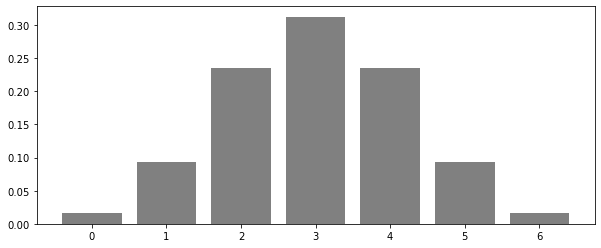

In [26]:
binomial = stats.binom(n=6, p=0.5)

fig, ax = plt.subplots(1, figsize=(10, 4))
_ = ax.bar(range(7), [binomial.pmf(i) for i in range(7)], color="grey")

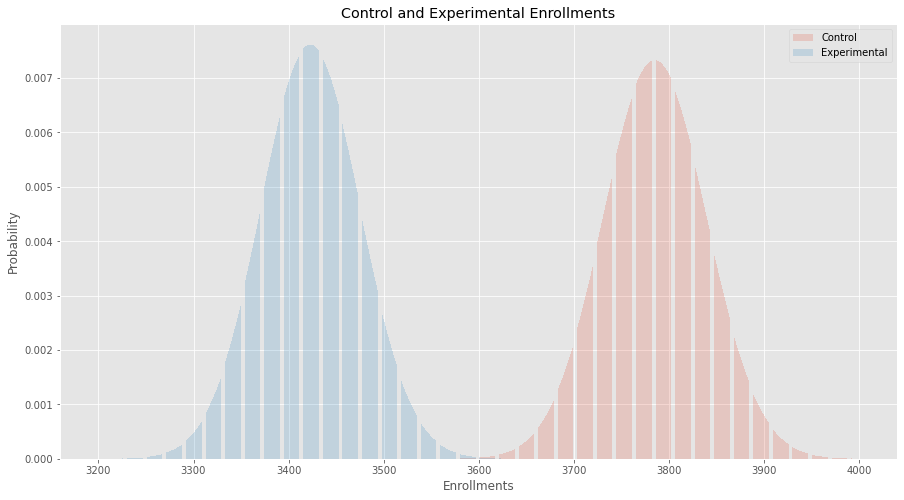

In [61]:
fig, ax = plt.subplots(1, figsize=(15,8))
x=np.arange(3200, 4000, 1)
control_binom=[stats.binom(n=control_clicks, p=(control_enroll/control_clicks)).pmf(i) for i in x]
exper_binom=[stats.binom(n=exper_clicks, p=(exper_enroll/exper_clicks)).pmf(i) for i in x]
ax.bar(x, control_binom, alpha=0.2, label="Control")
ax.bar(x, exper_binom, alpha=0.2, label="Experimental")
ax.set_title('Control and Experimental Enrollments')
ax.set_xlabel('Enrollments')
ax.set_ylabel('Probability')
ax.legend()
plt.savefig('Enrollment-control_exp')

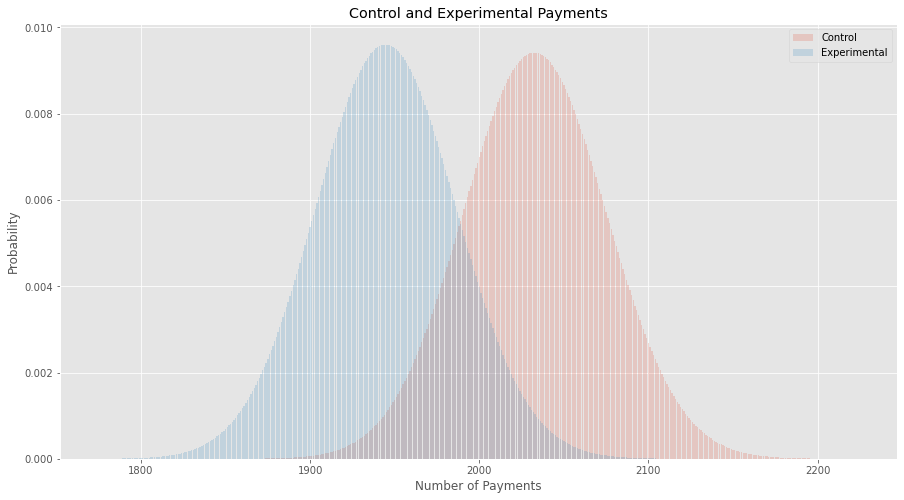

In [67]:
fig, ax = plt.subplots(1, figsize=(15,8))
x=np.arange(1775, 2225, 1)
control_binom=[stats.binom(n=control_clicks, p=(control_pay/control_clicks)).pmf(i) for i in x]
exper_binom=[stats.binom(n=exper_clicks, p=(exper_pay/exper_clicks)).pmf(i) for i in x]
ax.bar(x, control_binom, alpha=0.2, label="Control")
ax.bar(x, exper_binom, alpha=0.2, label="Experimental")
ax.set_title('Control and Experimental Payments')
ax.set_xlabel('Number of Payments')
ax.set_ylabel('Probability')
ax.legend()
plt.savefig('Payment-control_exp')

From these graphs it looks like it is likely that the enrollments vary, unlikely that payments vary.  A difference test will be performed to see if the difference between control and experimental groups vary in a statistically significant way.

In [75]:
def ttest_act(s1_act, s2_act, s1_cnt, s2_cnt, a=0.05):
    shared_freq=(s1_act+s2_act)/(s1_cnt+s2_cnt)
    shared_var=(s1_cnt+s2_cnt)*shared_freq*(1-shared_freq)/(s1_cnt*s2_cnt)
    difference_in_proportions = stats.norm(0, np.sqrt(shared_var))
    threshold=difference_in_proportions.ppf(1-a)
    diff=s1_act/s1_cnt-s2_act/s2_cnt
    p_val=1-difference_in_proportions.cdf(diff)
    print('threshold={:2.3f}, diff={:2.3f}, p_value={:2.3f}'.format(threshold, diff, p_val))
    return difference_in_proportions

In [77]:
ttest_act(control_enroll, exper_enroll, control_clicks, exper_clicks)

threshold=0.007, diff=0.021, p_value=0.000


In [79]:
ttest_act(control_pay, exper_pay, control_clicks, exper_clicks)

threshold=0.006, diff=0.005, p_value=0.078
